In [ ]:
"""
QPSK Transmitter + Receiver Simulation

1. Generate bits
2. QPSK modulation
3. Pulse filtering
4. Channel
5. Matched filter
6. Symbol timing synchronization
7. Carrier frequency and phase recovery
8. Demodulation
9. Analysis

TODO: 
- Add multipath effects to channel & equalizer
- Framing? Detect start of frame


Framing: 
1. Initial coarse CFO guess by examining phase drift of first correlation peak's preamble
2. Correct this CFO
3. Run frame detector on corrected symbols. Have this at 2+ SPS to make robust to fractional STO
4. On frame detection: Run data aided Costas, Gardner, etc. on preamble and decision-directed on payload. Coherently demodulate corrected payload
    - Occasionally update coarse CFO guess using phase drift of preamble correlation.



Date created: 6/9/25
Author: Cole Delong
"""

'\nQPSK Transmitter + Receiver Simulation\n\n1. Generate bits\n2. QPSK modulation\n3. Pulse filtering\n4. Channel\n5. Matched filter\n6. Symbol timing synchronization\n7. Carrier frequency and phase recovery\n8. Demodulation\n9. Analysis\n\nTODO: \n- Add multipath effects to channel & equalizer\n- Framing? Detect start of frame\n\n\nDate created: 6/9/25\nAuthor: Cole Delong\n'

In [1]:
# Reload imports every time this cell is run
%reload_ext autoreload
%autoreload 2

# Imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

import sys
sys.path.insert(0, '..')
# import importlib
# import utils
# importlib.reload(utils)
from utils import *

# Constants
SPS = int(2)
N_BITS = 10**6
N_SYMBOLS = int(N_BITS/2) + 1       # qpsk: 2 bits/sample, differential coding: +1 symbol
N_RRC_TAPS = SPS*10 + 1
SNR_DB = 20


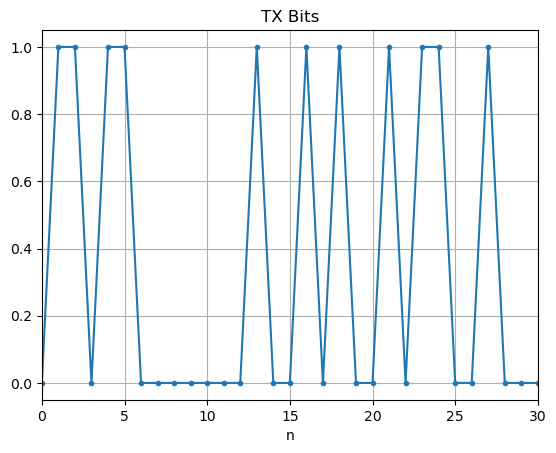

In [245]:
### Generate bits ###
bits_tx = np.random.randint(2, size=N_BITS)
plot_signal(bits_tx, title='TX Bits', xlim=[0, 30])

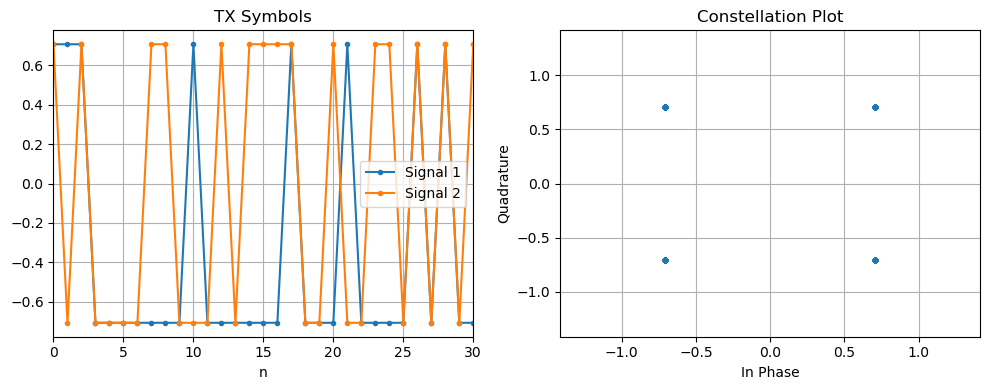

In [246]:
### QPSK modulation ###

# Use differential coding to account for phase ambiguity
sym_tx = diff_encode_psk_symbols(modulate_qpsk(bits_tx))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sym_tx.real, sym_tx.imag, title='TX Symbols', xlim=[0, 30], ax=axs[0])
plot_constellation(sym_tx, ax=axs[1])
plt.tight_layout()
plt.show()

/home/cddelong/sdr/sdr-notebooks/notebooks/../utils/visualization.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


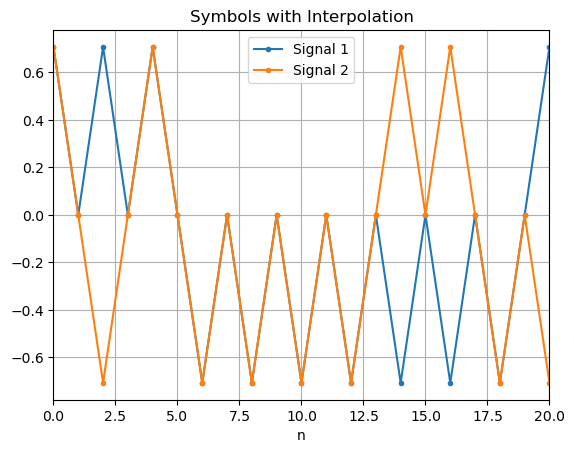

In [247]:
### Pulse filtering ###

# Upsample by factor of SPS
sym_upsamp = upsample(sym_tx, SPS)

plot_signal(sym_upsamp.real, sym_upsamp.imag, title='Symbols with Interpolation', xlim=[0, 10*SPS])

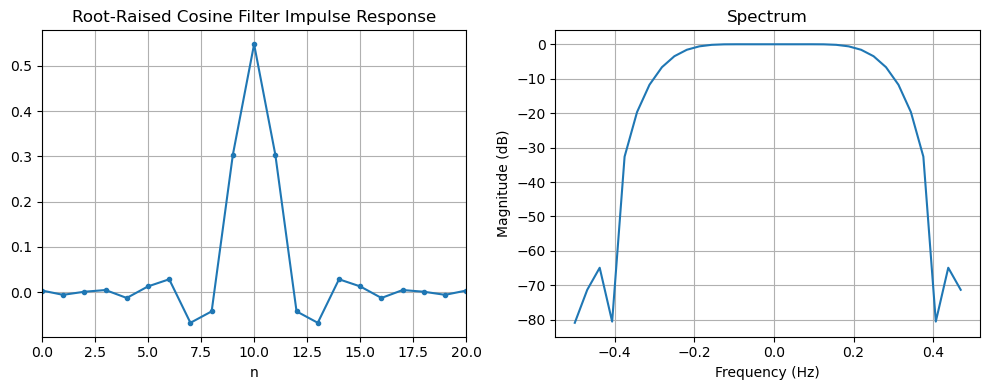

In [217]:
h_rrc = rrc(Ts=SPS, n_taps=N_RRC_TAPS)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(h_rrc.real, title='Root-Raised Cosine Filter Impulse Response', ax=axs[0])
plot_spectrum(h_rrc, ax=axs[1])
plt.tight_layout()
plt.show()

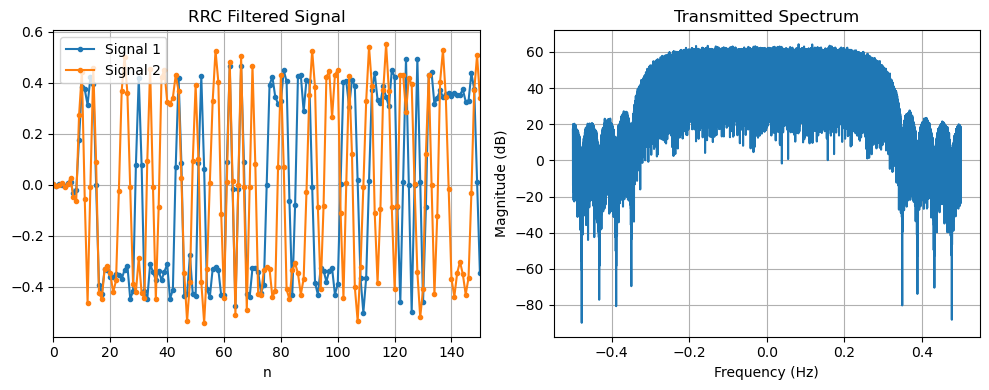

In [249]:
# Convolve signal with RRC filter
sig_tx = np.convolve(sym_upsamp, h_rrc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_tx.real, sig_tx.imag, title='RRC Filtered Signal', xlim=[0, 150], ax=axs[0])
plot_spectrum(sig_tx, title="Transmitted Spectrum", ax=axs[1])
plt.tight_layout()
plt.show()

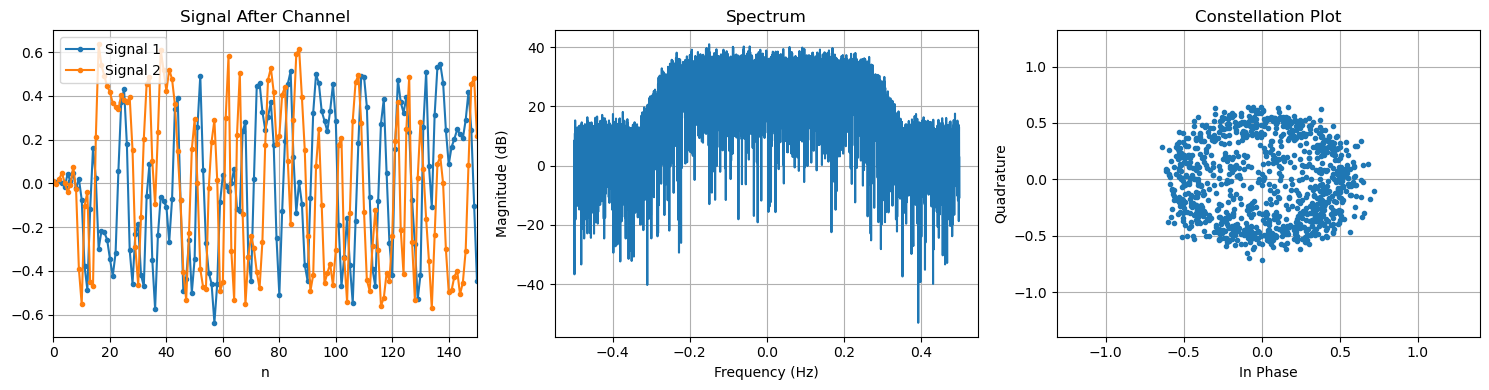

In [250]:
### Channel ###

# Apply CFO
# testing/realistic: 1-5%, aggressive: 10%
sig_chan = apply_cfo(sig_tx, 0.01)

# Apply CPO
sig_chan = apply_cpo(sig_chan)

# Apply STO
mu = 0.3
sig_chan = apply_sto(sig_chan, mu)

# AWGN
sig_rx = apply_awgn(sig_chan, SNR_DB)

# Visualize signal after channel
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sig_rx.real, sig_rx.imag, title='Signal After Channel', xlim=[0, 150], ax=axs[0])
plot_constellation(sig_rx, ax=axs[2])
plot_spectrum(sig_rx, n_samples=2**13, ax=axs[1])
plt.tight_layout()
plt.show()


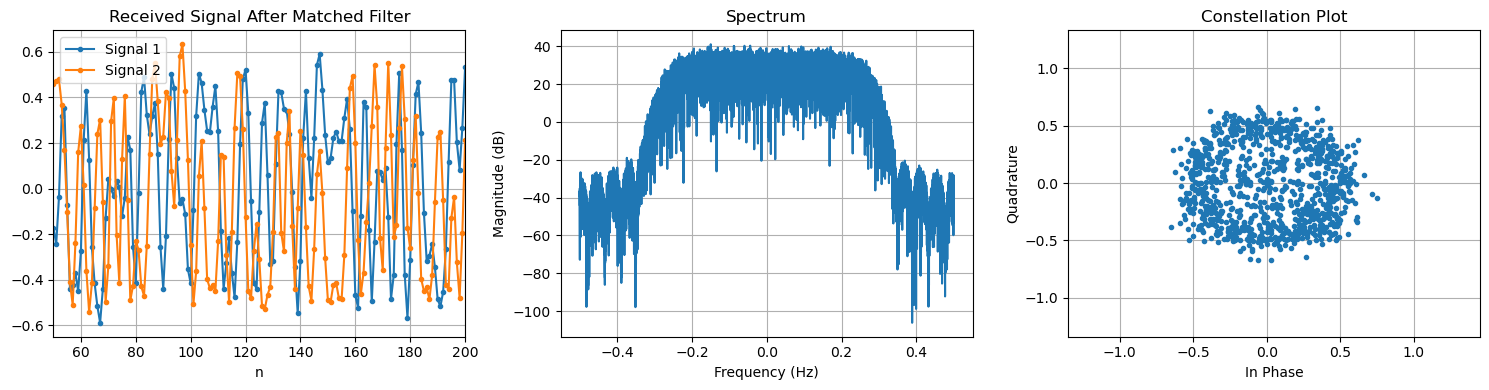

In [251]:
### Matched filter ###
sig_matched = np.convolve(sig_rx, h_rrc)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sig_matched.real, sig_matched.imag, xlim=[50, 200], title='Received Signal After Matched Filter', ax=axs[0])
plot_spectrum(sig_matched, n_samples=2**13, ax=axs[1])
plot_constellation(sig_matched, n_samples=1000, ax=axs[2])
plt.tight_layout()
plt.show()

# Remove extra samples from convolutions
sig_matched = sig_matched[N_RRC_TAPS-1 : (N_RRC_TAPS-1) * -1]


/home/cddelong/miniconda3/envs/dsp/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/cddelong/miniconda3/envs/dsp/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


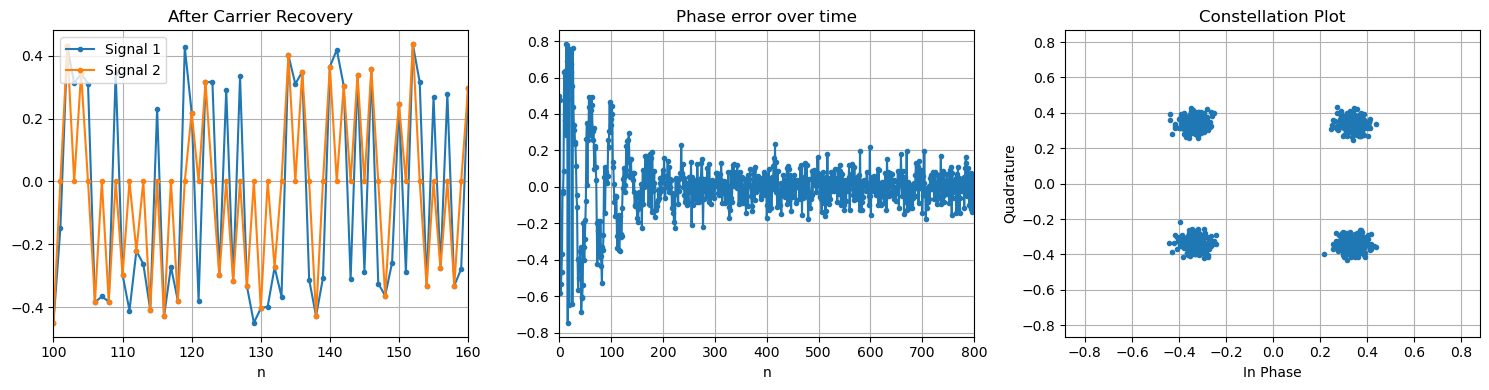

In [252]:
### Symbol Synchronization ###

"""
Gardner: 
- Low complexity
- 2x oversampling fine since sample rate is same for both rx and tx on PlutoSDR
- Better than M&M in lower SNR environments
- Real-time low-latency

cubic interpolation:
- Complexity not bad (better than sinc) when using Farrow structures
- More accurate than lower order quadratic interpolaters
"""



stc = GardnerSymbolTimingCorrector()
symbols_sampled = stc.correct_batch(sig_matched)


### Carrier Recovery ###
# 2nd Order Costas Loop
K_p = 0.04
K_i = 0.03

control = PIDFeedback(K_p, K_i)
lock_detector = PhaseLockDetector()
error = np.empty_like(symbols_sampled)
sym_rot = costas_loop(symbols_sampled, control, lock_detector, debug=error)
symbols = np.array([sym_rot[i]*(i % SPS == 0) for i in np.arange(sym_rot.size)], dtype=sym_rot.dtype)


# Add in before + after plots for (carrier recovery), (symbol timing recovery) 
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sym_rot.real, symbols.real, title='After Carrier Recovery', xlim=[50*SPS, 80*SPS], ax=axs[0])
plot_signal(error, title='Phase error over time', xlim=[0, 800], ax=axs[1])
plot_constellation(sym_rot[1000:], n_samples=1000, ax=axs[2])
plt.tight_layout()
plt.show()



In [253]:
### Demodulation ###

# Make optimum decision for AWGN channel
bits_rx = demodulate_qpsk(diff_decode_psk_symbols(optimum_decider_qpsk(sym_rot)))

print(f"BER: {np.mean(bits_tx != bits_rx)}")

BER: 2.5e-05


In [254]:
print(bits_tx[0:15])
print(bits_rx[0:15])
locs = []
for i in range(len(bits_tx)):
    if bits_tx[i] != bits_rx[i]:
        locs.append(i)

print(np.sum(bits_rx != bits_tx))

[0 1 1 0 1 1 0 0 0 0 0 0 0 1 0]
[0 0 0 0 1 0 1 1 0 0 0 0 0 0 0]
25


0.695862068610077



/home/cddelong/miniconda3/envs/dsp/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/cddelong/miniconda3/envs/dsp/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


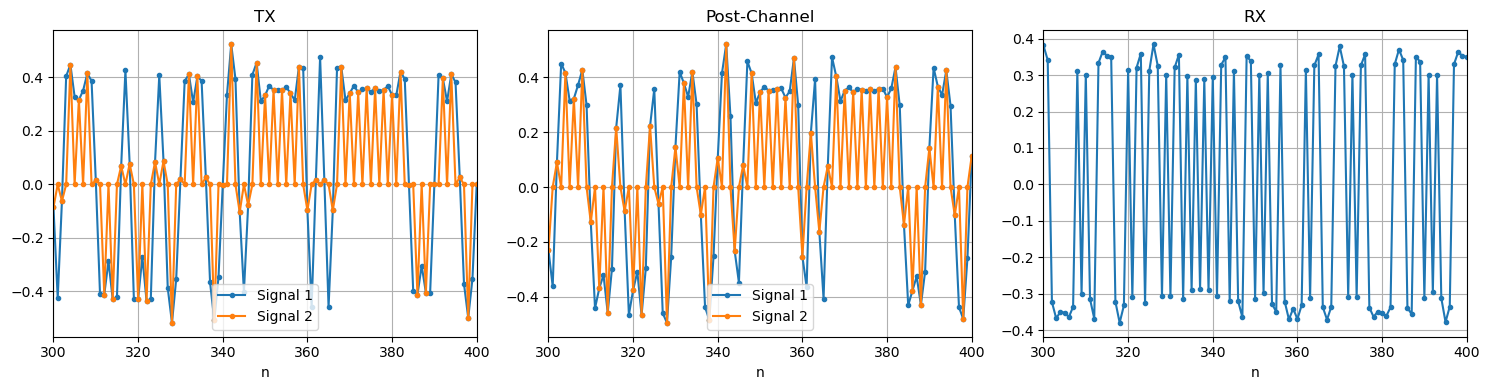

/home/cddelong/sdr/sdr-notebooks/notebooks/../utils/visualization.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


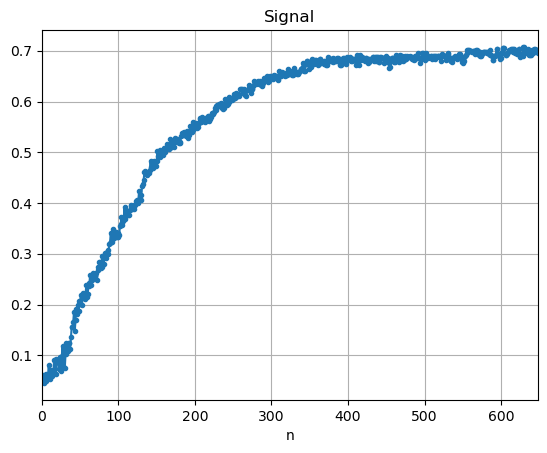

In [255]:

# Reload imports every time this cell is run
%reload_ext autoreload
%autoreload 2

# Imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

import sys
sys.path.insert(0, '..')
# import importlib
# import utils
# importlib.reload(utils)
from utils import *

# Constants
SPS = int(2)
N_BITS = 10**6
N_SYMBOLS = int(N_BITS/2) + 1       # qpsk: 2 bits/sample, differential coding: +1 symbol
N_RRC_TAPS = SPS*10 + 1
SNR_DB = 20




fig, axs = plt.subplots(1, 3, figsize=(15, 4))


SPS = 2
N_RRC_TAPS = SPS*10 + 1
N_SAMPS = 1300

# TX
h_rrc = rrc(Ts=SPS, n_taps=N_RRC_TAPS)
s = np.convolve(upsample(modulate_qpsk(np.random.randint(2, size=N_SAMPS)), SPS), h_rrc)[11:-10]
samples = np.array([s[i]*(i % SPS == 0) for i in np.arange(s.size)], dtype=s.dtype)
plot_signal(s, samples, title="TX", ax=axs[0], xlim=[300, 400])


# Channel
mu = 0.3
s = apply_sto(s, mu)

samples = np.array([s[i]*(i % SPS == 0) for i in np.arange(s.size)], dtype=s.dtype)

plot_signal(s, samples, title="Post-Channel", ax=axs[1], xlim=[300, 400])


# RX
s = np.convolve(s, h_rrc)[10:-10]
stc = GardnerSymbolTimingCorrector()
s = stc.correct_batch(batch=s[0:])
samples = np.array([s[i]*(i % SPS == 0) for i in np.arange(s.size)], dtype=s.dtype)
# plot_signal(s, samples, title="RX", ax=axs[2], xlim=[300, 400])
plot_signal(s, title="RX", ax=axs[2], xlim=[300, 400])
print(stc.mu)
print()

plt.tight_layout()
plt.show()

plot_signal(stc.mu_log, n_samps=len(stc.mu_log))


array([-2.30381689e-04,  1.95531169e-04,  5.98610782e-04,  9.78986646e-04,
        1.33680968e-03,  1.67225178e-03,  1.98550537e-03,  2.27678292e-03,
        2.54631654e-03,  2.79435749e-03,  3.02117577e-03,  3.22705962e-03,
        3.41231509e-03,  3.57726561e-03,  3.72225149e-03,  3.84762951e-03,
        3.95377246e-03,  4.04106868e-03,  4.10992161e-03,  4.16074932e-03,
        4.19398411e-03,  4.21007200e-03,  4.20947231e-03,  4.19265722e-03,
        4.16011128e-03,  4.11233098e-03,  4.04982431e-03,  3.97311027e-03,
        3.88271849e-03,  3.77918868e-03,  3.66307026e-03,  3.53492187e-03,
        3.39531093e-03,  3.24481319e-03,  3.08401226e-03,  2.91349918e-03,
        2.73387196e-03,  2.54573513e-03,  2.34969928e-03,  2.14638062e-03,
        1.93640053e-03,  1.72038508e-03,  1.49896462e-03,  1.27277330e-03,
        1.04244864e-03,  8.08631028e-04,  5.71963347e-04,  3.33090458e-04,
        9.26587794e-05, -1.48684177e-04, -3.90290250e-04, -6.31511086e-04,
       -8.71698588e-04, -

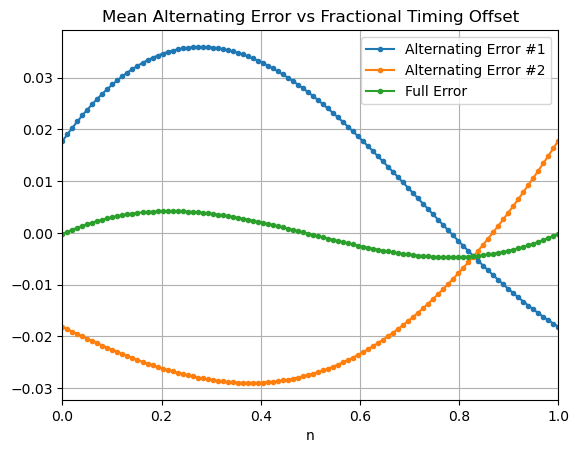

In [256]:
farrow = CubicFarrowInterpolator()

a = farrow.process_batch_with_tail_padding(np.array([0, 1, 2, 3, 4, 5]), .5)
# a = farrow.process_batch(np.array([0, 1, 2, 3, 4, 5]), 0.5)
# print(a.real)



# x = np.linspace(0, 2 * np.pi, 100)  # Generates 100 points between 0 and 2π
# b1 = np.sin(x*20)

b1 = np.array([1, 0, -1, 0] * 40)
b2 = apply_sto(b1, 0.7)
b3 = apply_sto(b2, 0.3, 1)
# plot_signal(b1, b2, b3, n_samps=10)

def func(mu):

    N_SAMPS=700
    s = np.convolve(upsample(modulate_qpsk(np.random.randint(2, size=N_SAMPS)), SPS), h_rrc)
    # s = upsample(modulate_qpsk(np.random.randint(2, size=N_SAMPS)), SPS)
    # s = np.array([1, 0, -1, 0] * (N_SAMPS//4))
    s = apply_sto(s, mu)
    s = np.convolve(s, h_rrc)[20:-20]

    # s = apply_sto(s, 0.3)
    # plot_signal(s[0:100])

    mu = np.linspace(0, 1, 100)
    # mean_e = np.zeros(len(s)+1)
    all_e = np.empty((0, len(mu)))  # empty array with 0 rows, len(mu) columns


    farrow.reset()
    for i, samp in enumerate(s):
        farrow.load(samp)
        # all_e = np.append(all_e, [gardner_ted(m, farrow) for m in mu], axis=0)
        # all_e = np.vstack([all_e, [gardner_ted(m, farrow) for m in mu]])
        row = [GardnerSymbolTimingCorrector.ted(m, farrow) for m in mu]
        all_e = np.vstack([all_e, row])  # append row to all_e
        # print(all_e)

    mean_e0 = np.array([])
    mean_e1 = np.array([])
    mean_e_tot = np.array([])
    for i in range(len(mu)):
        mean_e0 = np.append(mean_e0, np.mean(all_e[:, i][0::2]))
        mean_e1 = np.append(mean_e1, np.mean(all_e[:, i][1::2]))
        mean_e_tot = np.append(mean_e_tot, np.mean(all_e[:, i]))

    fig = plot_signal(mean_e0, mean_e1, mean_e_tot, title='Mean Alternating Error vs Fractional Timing Offset', label=['Alternating Error #1', 'Alternating Error #2', 'Full Error'], x=mu)
    # fig.savefig('gardner_every_other_sample.png', dpi=90, bbox_inches="tight")

    return mean_e_tot

func(0.2)
# fig = plot_signal(func(0.2), func(0.4), func(0.6), func(0.8), title='Mean Gardner Error vs Fractional Timing Offset', xlabel='Fractional Timing Offset', ylabel='Mean Gardner Error',
            # label=['mu=0.2', 'mu=0.4', 'mu=0.6', 'mu=0.8'])
# fig.savefig('gardner_every_sample.png', dpi=90, bbox_inches="tight")
# plot_signal(func(0.6), title='Mean Gardner Error vs Fractional Timing Offset', xlabel='Fractional Timing Offset', ylabel='Mean Gardner Error')

# s = np.convolve(apply_sto(s, 0.7), h_rrc)[n:(n+15)]
# plot_signal(s)
# farrow.load(s)
# print(f"buffer {list(farrow.buffer)}")

# mu = np.linspace(0, 1, 100)
# e = np.array([gardner_ted(m, farrow) for m in mu])
# plot_signal(e, x=mu)



# help(np.arange)

0.3141592653589793
True
-0.05827147663916589


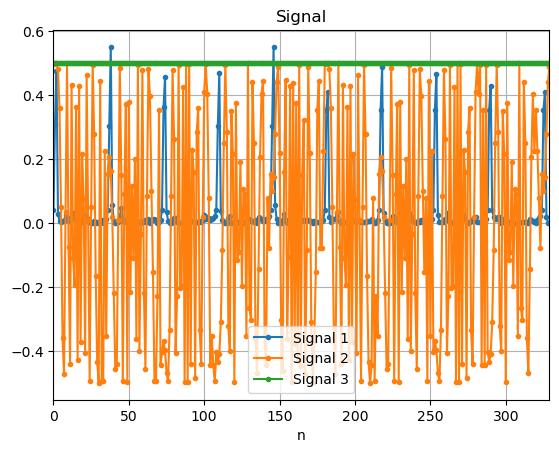

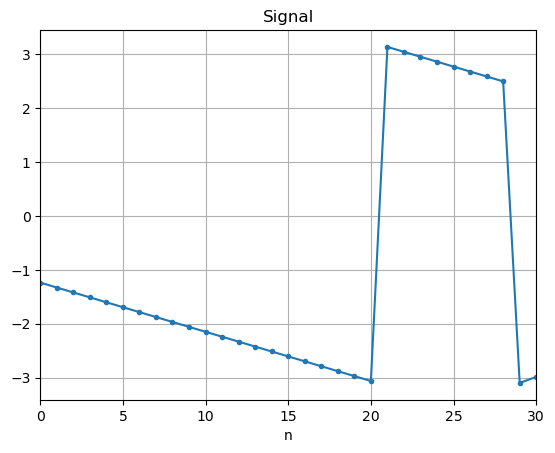

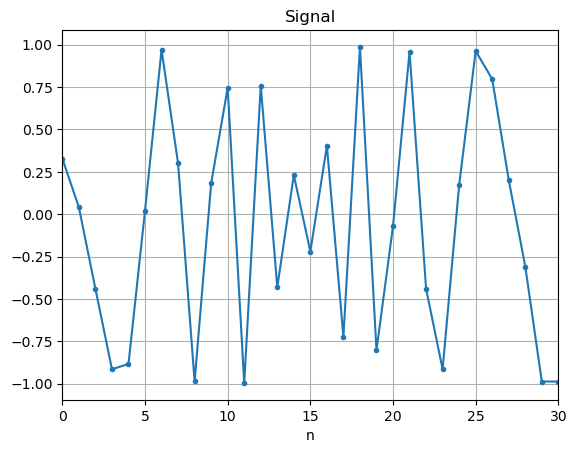

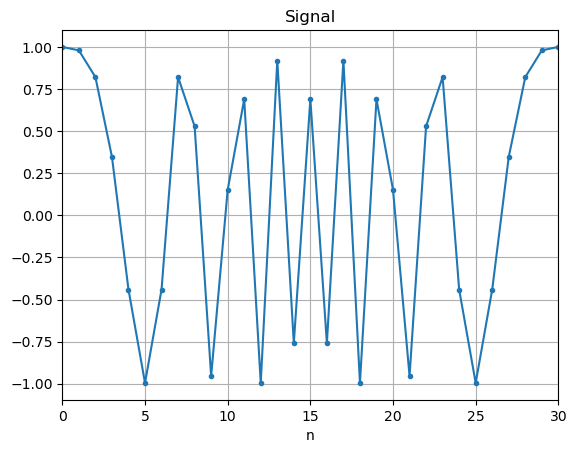

In [232]:



import sys
sys.path.insert(0, '..')

from scipy import signal
import numpy as np
from utils import *

# np.random.seed(0)

preamble = zadoff_chu(31)

payload = modulate_qpsk(np.random.randint(2, size=100))
len_payload = 5
frames = to_frames(preamble, payload, len_payload)


# sig = apply_fto(frames, 200)
sig = np.concat(frames)
# sig = apply_awgn(sig, 10)
# sig = apply_sto(sig, 0.7)
pct = 0.05

sig = apply_cfo(sig, pct)

print(pct*(2*np.pi))

t = 0.5

fsm = FramingStateMachine(preamble, len(preamble)+len_payload, t)
detected_frames = fsm.update(sig)


ccc = CoarseCFOCorrector(preamble)
print(ccc.guess(sig))
print(ccc.w_est)


t_vec = t * np.ones_like(sig)
plot_signal(fsm.test, sig*0.5, t_vec, n_samps=len(sig))

plot_signal(ccc.test[0])
plot_signal(ccc.test[1])
plot_signal(ccc.test[2])

# print(np.mean(ccc.test[0]))

# frames_out = np.concatenate(frames)
# frames_in = np.concatenate(detected_frames)

# plot_signal(frames_out, frames_in)




0.3141592653589793


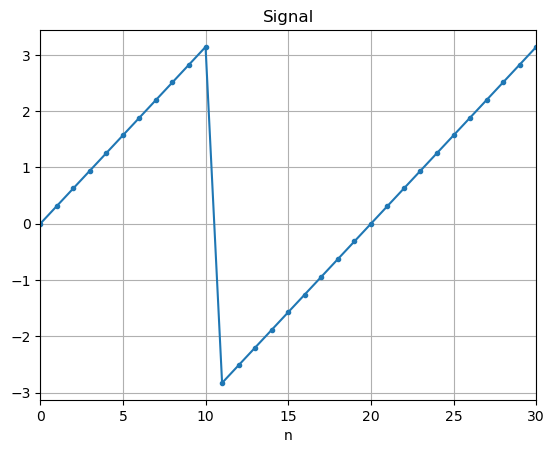

In [215]:
pct = 0.05
print(pct*(2*np.pi))

sig_0 = zadoff_chu(31)
sig_1 = apply_cfo(sig_0, pct)

phase_off = np.angle(sig_1 / sig_0)
rel_phase_off = phase_off[1:] - phase_off[:-1]
w_est = np.mean(rel_phase_off)

# plot_signal(sig_0)
# plot_signal(sig_1)
plot_signal(phase_off)
